## Imports

In [47]:
from context import utils, maml

In [48]:
import yaml
from torch import optim
import matplotlib.pyplot as plt
import numpy as np
import torch

## Parameters

In [49]:
with open('configs/maml_config.yaml', 'r') as yaml_file:
        spec_params = yaml.load(yaml_file, yaml.SafeLoader)
        
with open('configs/test_base_config.yaml', 'r') as base_yaml_file:
        base_params = yaml.load(base_yaml_file, yaml.SafeLoader)

In [50]:
maml_parameters = utils.parameters.MAMLParameters(base_params)

In [51]:
maml_parameters.update(spec_params)
maml_parameters.set_property('device', 'cpu')

In [52]:
maml_parameters.show_all_parameters()

{'experiment_name': 'vanilla', 'seed': 0, 'use_gpu': False, 'resume': {'model': None, 'priority_queue': None, 'queue_counts': None}, 'task_type': 'sin', 'training_iterations': 10000000, 'task_batch_size': 25, 'meta_lr': 0.01, 'inner_update_k': 10, 'inner_update_lr': 0.01, 'num_inner_updates': 1, 'validation_num_inner_updates': 5000, 'validation_k': 200, 'test_k': 10, 'validation_task_batch_size': 10, 'validation_frequency': 10, 'visualisation_frequency': 10, 'visualise_all': False, 'x_dim': 1, 'input_dimension': 1, 'network_layers': [40, 40], 'output_dimension': 1, 'fixed_validation': False, 'priority_sample': False, 'sin': {'domain_bounds': [-5, 5], 'amplitude_bounds': [0.1, 5], 'phase_bounds': [0, 180], 'fixed_val_blocks': [0.1, 5]}, 'priority_queue': {'sample_type': 'epsilon_greedy', 'epsilon_start': 1.0, 'epsilon_final': 0.1, 'epsilon_decay_start': 10000000, 'epsilon_decay_rate': 1e-07, 'block_sizes': [0.1, 5], 'param_ranges': [[0.1, 5], [0, 180]], 'burn_in': None, 'initial_value':

## Init Sine MAML Class (For batch generation only)

In [53]:
SM = maml.sinusoid.SineMAML(maml_parameters, 'cpu')

In [54]:
generate_batch = SM._generate_batch

In [55]:
sample_task = SM._sample_task

In [56]:
compute_loss = SM._compute_loss

## Train network (Standard PyTorch Network)

In [57]:
def train(k, num, network, x, y, lr):
    
    optimiser = optim.Adam(network.parameters(), lr=lr)

    losses = []

    for i in range(num):

        pred_y = network(x)

        loss = compute_loss(pred_y, y)

        losses.append(float(loss.detach()))

    #     print(i, loss)

        optimiser.zero_grad()

        loss.backward()

        optimiser.step()
    
    return losses, network

## Plot losses

In [58]:
def plot_losses(losses):
    fig = plt.figure()
    plt.plot(range(len(losses)), losses)
    plt.xlabel("step")
    plt.ylabel("loss")
    fig.show()

## Show Qualitative Regression

In [59]:
def show_regression(task, x, y, network):
    x_plot = np.linspace(-5, 5, 100)
    y_plot = [task(xi) for xi in x_plot]
    
    plot_x_tensor = torch.tensor([[x] for x in x_plot])
    
    fig = plt.figure()
    plt.plot(x_plot, y_plot)
    plt.scatter(x, y)
    
    pred_y = network(plot_x_tensor)
    
    plt.plot(x_plot, pred_y.cpu().detach().numpy())
    
    fig.show()

In [60]:
def whole_ting(n, k, task, x, y, lr=0.01):
    SN = maml.sinusoid._SinusoidalNetwork(maml_parameters)
    test = train(k=k, num=n, network=SN, x=x, y=y, lr=lr)
    show_regression_mod(task, x, y, test[1])

## Train Modified PyTorch Network

In [61]:
def train_mod(k, num, network, x, y, lr=0.01):

    losses = []

    for i in range(num):

        pred_y = network(x)

        loss = compute_loss(pred_y, y)

        losses.append(float(loss.detach()))

        gradients = torch.autograd.grad(loss, network.weights + network.biases, create_graph=True, retain_graph=True)

        # update inner model using current model 
        for i in range(len(network.weights)):
            network.weights[i] = network.weights[i] - lr * gradients[i].detach()
        for j in range(len(network.biases)):
            network.biases[j] = network.biases[j] - lr * gradients[i + j + 1].detach()
    
    return losses, network

In [62]:
def show_regression_mod(task, x, y, network):
    x_plot = np.linspace(-5, 5, 100)
    y_plot = [task(xi) for xi in x_plot]
    
    plot_x_tensor = torch.tensor([[x] for x in x_plot])
    
    fig = plt.figure()
    plt.plot(x_plot, y_plot)
    plt.scatter(x, y)
    
    pred_y = network(plot_x_tensor)
    
    plt.plot(x_plot, pred_y.cpu().detach().numpy())
    
    fig.show()

In [63]:
def whole_ting_mod(n, k, task, x, y, seed_value=0):
    import torch
    import numpy as np
    import random
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    
    SN = maml.sinusoid.SinusoidalNetwork(maml_parameters)
    test = train_mod(k=k, num=n, network=SN, x=x, y=y)
    show_regression_mod(task, x, y, test[1])

In [48]:
task = sample_task()
x, y = generate_batch(task, batch_size=100)

/Users/sebastianlee/Dropbox/Documents/Work/Hack/Environments/meta/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


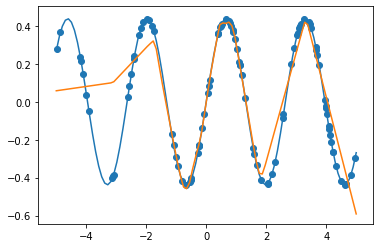

In [54]:
whole_ting(100,10,task,x,y)

In [ ]:
whole_ting_mod(100,10,task,x,y)

## Test Semi-Manual Regression

In [69]:
def train_mod2(k, num, network, x, y, lr=0.01):

    losses = []
    
    optimiser = optim.Adam(network.weights + network.biases, lr=lr)

    for i in range(num):

        pred_y = network(x)

        loss = compute_loss(pred_y, y)

        losses.append(float(loss.detach()))

        gradients = torch.autograd.grad(loss, network.weights + network.biases, create_graph=True, retain_graph=True)
        
        optimiser.zero_grad()

        # update inner model using current model 
        for i in range(len(network.weights)):
            network.weights[i].grad = gradients[i].detach()
        for j in range(len(network.biases)):
            network.biases[j].grad = gradients[i + j + 1].detach()
            
        optimiser.step()
    
    return losses, network

In [65]:
def show_regression_mod2(task, x, y, network):
    x_plot = np.linspace(-5, 5, 100)
    y_plot = [task(xi) for xi in x_plot]
    
    plot_x_tensor = torch.tensor([[x] for x in x_plot])
    
    fig = plt.figure()
    plt.plot(x_plot, y_plot)
    plt.scatter(x, y)
    
    pred_y = network(plot_x_tensor)
    
    plt.plot(x_plot, pred_y.cpu().detach().numpy())
    
    fig.show()

In [66]:
def whole_ting_mod2(n, k, task, x, y, seed_value=0):
    import torch
    import numpy as np
    import random
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    
    SN = maml.sinusoid.SinusoidalNetwork(maml_parameters)
    test = train_mod2(k=k, num=n, network=SN, x=x, y=y)
    show_regression_mod2(task, x, y, test[1])

In [67]:
task = sample_task()
x, y = generate_batch(task, batch_size=100)

/Users/sebastianlee/Dropbox/Documents/Work/Hack/Environments/meta/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


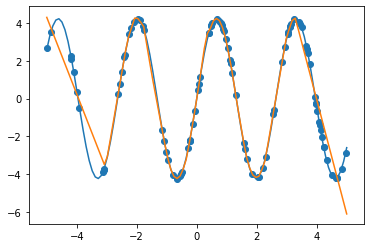

In [73]:
whole_ting_mod2(2000,150,task,x,y)

/Users/sebastianlee/Dropbox/Documents/Work/Hack/Environments/meta/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


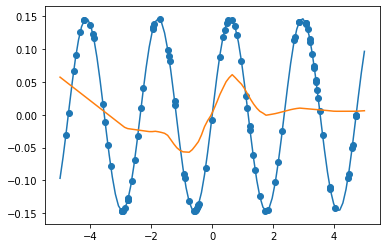

In [31]:
whole_ting_mod(1000,10,task,x,y)

In [41]:
whole_ting_mod2(1000,10,task,x,y)

RuntimeError: Can't detach views in-place. Use detach() instead

/Users/sebastianlee/Dropbox/Documents/Work/Hack/Environments/meta/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


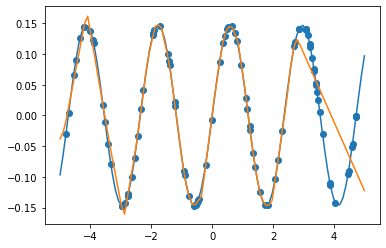

In [39]:
whole_ting(1000,10,task,x,y)

In [42]:
a = 5

In [43]:
b = a

In [44]:
b = 6

In [45]:
a

5